# ES-KMeans Example

An example of doing unsupervised acoustic word segmentation and clustering using the embedded segmental K-means (ES-KMeans) algorithm. The algorithm is described in:

- H. Kamper, K. Livescu, and S. J. Goldwater, "An embedded segmental K-means model for unsupervised segmentation and clustering of speech," in *Proc. ASRU*, 2017. [[arXiv](https://arxiv.org/abs/1703.08135)]

Please cite this paper if you use the code.

This notebook gives a minimal working example on a small corpus of three utterances. The utterances were taken from the Brent corpus, but I replaced the word "kitty" with my own cat's name. Because the corpus is small (and the algorithm also has shortcomings), the results are far from perfect. Nevertheless, the notebook gives a complete example of all the necessary steps.

## Preliminaries

Install dependencies:

In [31]:
! pip install -q librosa
! pip install -q git+https://github.com/detly/gammatone.git

Install [ES-KMeans](https://github.com/kamperh/eskmeans/):

In [15]:
# To-do: Update path below.
! mkdir ../src/
! git clone /media/kamperh/endgame/projects/stellenbosch/src/eskmeans ../src/eskmeans/

Cloning into '../src/eskmeans'...
done.


In [32]:
%matplotlib inline

from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as signal
import sys
import IPython

eskmeans_dir = Path("..")/"src"/"eskmeans"
sys.path.append(str(eskmeans_dir))
sys.path.append(str(eskmeans_dir/"utils"))

from eskmeans import eskmeans_wordseg
import theta_oscillator

## Data and speech feature extraction

Download data:

In [38]:
# To-do: Update path below
! wget https://github.com/kamperh/blah_blah/luna.zip
! unzip luna.zip

--2021-02-15 11:23:17--  https://github.com/kamperh/blah_blah/luna.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-02-15 11:23:18 ERROR 404: Not Found.

Archive:  luna.zip
replace brent_01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Extract speech features:

In [39]:
wav_fns = ["brent_01.wav", "brent_02.wav", "brent_03.wav"]
audio_dict = {}
mfcc_dict = {}
fs = 16000
for wav_fn in wav_fns:
    utt_key = Path(wav_fn).stem
    audio, _ = librosa.load(wav_fn, fs)
    audio_dict[utt_key] = audio
    mfcc_dict[utt_key] = librosa.feature.mfcc(
        audio, sr=fs, n_mfcc=13, n_mels=24,
        n_fft=int(np.floor(0.025*fs)),
        hop_length=int(np.floor(0.01*fs)),
        fmin=64, fmax=8000,
        ).T

In [41]:
IPython.display.Audio(audio_dict["brent_03"], rate=fs)

## Unsupervised syllable boundary detection

As a preprocessing step, we constrain the allowed word boundary positions to boundaries detected by an unsupervised syllable boundary detection algorithm. The potential boundary positions are referred to as "landmarks". The algorithm used to perform the syllable boundary detection is provided in the `theta_oscillator` module.

In [46]:
landmarks_dict = {}
for utt_key in audio_dict:
    boundaries = theta_oscillator.get_boundaries(
        audio_dict[utt_key], fs=fs
        )
    landmarks_dict[utt_key] = list(
        np.asarray(np.ceil(boundaries*100), dtype=np.int32)
        )[1:]  # strip first 0

For each possible word segment, we are going to extract an acoustic word embedding. We therefore construct a list of all the possible `(start, end)` positions, where `start` and `end` corresponds to detected syllable boundaries.

In [47]:
def get_seglist_from_landmarks(landmarks, n_landmarks_max):
    seglist = []
    prev_landmark = 0
    for i in range(len(landmarks)):
        for j in landmarks[i:i + n_landmarks_max]:
            seglist.append((prev_landmark, j))
        prev_landmark = landmarks[i]
    return seglist

In [48]:
# Find all the possible segmentation intervals
n_landmarks_max = 6
seglist_dict = {}
for utt_key in mfcc_dict:
    seglist_dict[utt_key] = get_seglist_from_landmarks(
        landmarks_dict[utt_key], n_landmarks_max
        )

In [49]:
print(landmarks_dict["brent_02"])
print(seglist_dict["brent_02"])

[52, 70, 92, 120, 180]
[(0, 52), (0, 70), (0, 92), (0, 120), (0, 180), (52, 70), (52, 92), (52, 120), (52, 180), (70, 92), (70, 120), (70, 180), (92, 120), (92, 180), (120, 180)]


Text(0.5, 0, 'Time (s)')

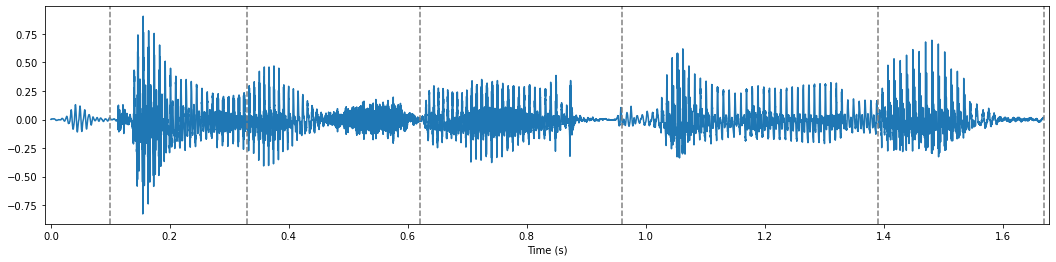

In [50]:
# Plot syllable boundaries
utt_key = "brent_01"
wav = audio_dict[utt_key]

plt.figure(figsize=(18, 4))
plt.plot(np.arange(len(wav))/fs, wav)
plt.xlim([-0.01, (len(wav))/fs + 0.01])

for landmark_frame in landmarks_dict[utt_key]:
    plt.axvline(landmark_frame/100, ymin=0, ymax=1, color="grey", linestyle="dashed")

plt.xlabel ("Time (s)")

## Downsampled acoustic word embeddings

Downsamples acoustic word embeddings are extracted for each potential word segment.

In [51]:
def downsample_utterance(features, seglist, n):
    """
    Return the downsampled matrix with each row an embedding for a segment in
    the seglist.
    """
    embeddings = []
    for i, j in seglist:
        y = features[i:j+1, :].T
        y_new = signal.resample(y, n, axis=1).flatten("C")
        embeddings.append(y_new)
    return np.asarray(embeddings)

In [52]:
downsample_dict = {}
for utt_key in mfcc_dict:
    downsample_dict[utt_key] = downsample_utterance(
        mfcc_dict[utt_key][:, :13], seglist_dict[utt_key], n=10
        )

## Intermediate variables for segmentation

In [53]:
# Utility functions

def get_vec_ids_dict(lengths_dict, n_landmarks_max):
    """
    Every N(N + 1)/2 length vector `vec_ids` contains all the indices for a
    particular utterance. For t = 1, 2, ..., N the entries `vec_ids[i:i
    + t]` contains the IDs of embedding[0:t] up to embedding[t - 1:t], with i =
    t(t - 1)/2. Written out: `vec_ids` = [embed[0:1], embed[0:2], embed[1:2],
    embed[0:3], ..., embed[N-1:N]].
    """
    vec_ids_dict = {}
    for utt in sorted(lengths_dict.keys()):
        i_embed = 0
        n_slices = lengths_dict[utt]
        vec_ids = -1*np.ones(int((n_slices**2 + n_slices)/2), dtype=int)
        for cur_start in range(n_slices):
            for cur_end in range(cur_start, min(n_slices, cur_start + n_landmarks_max)):
                cur_end += 1
                t = cur_end
                i = t*(t - 1)/2
                vec_ids[int(i + cur_start)] = i_embed
                i_embed += 1
        vec_ids_dict[utt] = vec_ids
    return vec_ids_dict


def get_durations_dict(landmarks_dict, n_landmarks_max):
    durations_dict = {}
    for utt in sorted(landmarks_dict.keys()):
        landmarks = [0,] + landmarks_dict[utt]
        N = len(landmarks)  # should be n_slices + 1
        durations = -1*np.ones(int(((N - 1)**2 + (N - 1))/2), dtype=int)
        j = 0
        for t in range(1, N):
            for i in range(t):
                if t - i > N - 1:
                    j += 1
                    continue
                durations[j] = landmarks[t] - landmarks[i]
                j += 1
        durations_dict[utt] = durations
    return durations_dict

In [54]:
# Intermediate variables
lengths_dict = dict([(i, len(landmarks_dict[i])) for i in landmarks_dict.keys()])
vec_ids_dict = get_vec_ids_dict(lengths_dict, n_landmarks_max)
durations_dict = get_durations_dict(landmarks_dict, n_landmarks_max)

## Unsupervised segmentation and clustering

In [55]:
random.seed(2)
np.random.seed(2)

# Model
K_max = 5
ksegmenter = eskmeans_wordseg.ESKmeans(
    K_max=K_max,
    embedding_mats=downsample_dict, vec_ids_dict=vec_ids_dict,
    durations_dict=durations_dict, landmarks_dict=landmarks_dict,
    p_boundary_init=0.5,
    n_slices_min=0,
    n_slices_max=n_landmarks_max,
    min_duration=20,
    init_assignments="spread",
    wip=0
    )

Initializing boundaries randomly with probability 0.5
No. initial embeddings: 13


In [56]:
# Preliminary K-means clustering
# segmenter_record = ksegmenter.acoustic_model.fit(n_iter=1, consider_unassigned=False)

In [57]:
# Segment
segmenter_record = ksegmenter.segment(n_iter=5)

Segmenting for 5 iterations
Iteration: 0, components: 5, n_tokens: 11, sample_time: 0.0034372806549072266, sum_neg_len_sqrd_norm: -13785903.061523438, sum_neg_sqrd_norm: -86487.95111545648
Iteration: 1, components: 5, n_tokens: 11, sample_time: 0.002480030059814453, sum_neg_len_sqrd_norm: -4990775.428222656, sum_neg_sqrd_norm: -86487.95111545648
Iteration: 2, components: 5, n_tokens: 11, sample_time: 0.002520322799682617, sum_neg_len_sqrd_norm: -4990775.428222656, sum_neg_sqrd_norm: -86487.95111545648
Iteration: 3, components: 5, n_tokens: 11, sample_time: 0.0023250579833984375, sum_neg_len_sqrd_norm: -4990775.428222656, sum_neg_sqrd_norm: -86487.95111545648
Iteration: 4, components: 5, n_tokens: 11, sample_time: 0.002330780029296875, sum_neg_len_sqrd_norm: -4990775.428222656, sum_neg_sqrd_norm: -86487.95111545648


In [58]:
# Obtain clusters and landmarks (frame indices)
unsup_transcript = {}
unsup_landmarks = {}
for i_utt in range(ksegmenter.utterances.D):
    utt = ksegmenter.ids_to_utterance_labels[i_utt]
    unsup_transcript[utt] = ksegmenter.get_unsup_transcript_i(i_utt)
    if -1 in unsup_transcript[utt]:
        logger.warning(
            "Unassigned cuts in: " + utt + " (transcript: " +
            str(unsup_transcript[utt]) + ")"
            )
    unsup_landmarks[utt] = (
        ksegmenter.utterances.get_segmented_landmarks(i_utt)
        )

In [59]:
unsup_transcript

{'brent_01': [1, 0], 'brent_02': [1, 3, 4, 2], 'brent_03': [1, 0, 3, 4, 2]}

In [60]:
# Analyze clusters
# clusters_dict[k] is a list of (utt_key, start, end) of cluster k
clusters_dict = {}
for utt_key in unsup_transcript:
    for i, cluster in enumerate(unsup_transcript[utt_key]):
        if cluster not in clusters_dict:
            clusters_dict[cluster] = []
        start, end = unsup_landmarks[utt_key][i]
        clusters_dict[cluster].append((utt_key, start, end))

In [61]:
# Create audio of clusters
clusters_audio = {}
pause_t = 0.25
for cluster in sorted(clusters_dict):
    if not cluster in clusters_audio:
        clusters_audio[cluster] = []
    for utt_key, start_frame, end_frame in clusters_dict[cluster]:
        start_sample = int(start_frame/100*fs)
        end_sample = int(end_frame/100*fs)
        clusters_audio[cluster].append(audio_dict[utt_key][start_sample:end_sample])
        clusters_audio[cluster].append(np.zeros(int(pause_t*fs)))
for cluster in clusters_audio:
    clusters_audio[cluster] = np.hstack(clusters_audio[cluster])

In [62]:
print("-"*39)
for cluster in sorted(clusters_dict):
    print("Cluster {}".format(cluster))
    for utt_key, start_frame, end_frame in clusters_dict[cluster]:
        print("Utterance {}: frames {} to {}".format(utt_key, start_frame, end_frame))
    print("-"*39)

---------------------------------------
Cluster 0
Utterance brent_01: frames 139 to 167
Utterance brent_03: frames 44 to 95
---------------------------------------
Cluster 1
Utterance brent_01: frames 0 to 139
Utterance brent_02: frames 0 to 52
Utterance brent_03: frames 0 to 44
---------------------------------------
Cluster 2
Utterance brent_02: frames 120 to 180
Utterance brent_03: frames 164 to 191
---------------------------------------
Cluster 3
Utterance brent_02: frames 52 to 92
Utterance brent_03: frames 95 to 138
---------------------------------------
Cluster 4
Utterance brent_02: frames 92 to 120
Utterance brent_03: frames 138 to 164
---------------------------------------


You can listen to the different clusters by changing the cluster index:

In [66]:
cluster = 3
IPython.display.Audio(clusters_audio[cluster], rate=fs)

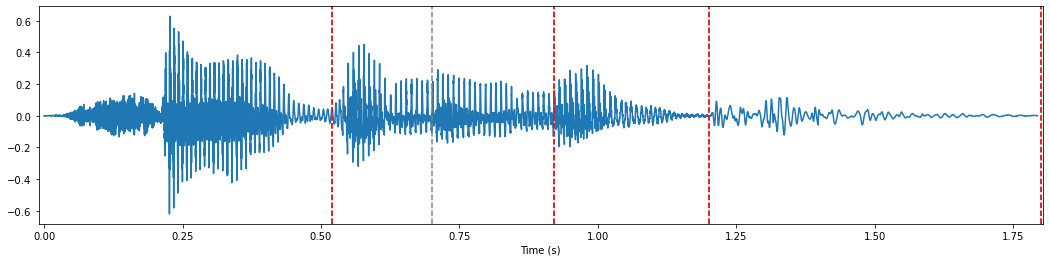

In [64]:
# Plot syllable and word boundaries
utt_key = "brent_02"
wav = audio_dict[utt_key]

plt.figure(figsize=(18, 4))
plt.plot(np.arange(len(wav))/fs, wav)
plt.xlim([-0.01, (len(wav))/fs + 0.01])

for landmark_frame in landmarks_dict[utt_key]:
    plt.axvline(landmark_frame/100, ymin=0, ymax=1, color="grey", linestyle="dashed")

for start_frame, end_frame in unsup_landmarks[utt_key]:
    plt.axvline(end_frame/100, ymin=0, ymax=1, color="r", linestyle="dashed")

plt.xlabel ("Time (s)");

In the figure above, the grey dashed lines indicate positions where we would be allowed to place word boundaries according to the syllable boundary detector. The red dashed lines indicate the positions where the model actually places the word boundaries.